<a href="https://colab.research.google.com/github/jessicaa-huang/spatial-vision/blob/main/graph_depth_mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read in xml file from CVAT annotations

In [ ]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
tree = ET.parse('annotations.xml')
root = tree.getroot()

In [ ]:
# List to store box coordinates
pommel_bbox = []
handle_bbox = []
blade_bbox = []
rock_bbox = []

# Iterate over each <image> element
for image in root.findall('image'):
    image_name = image.get('name')

    # Iterate over each <box> element within the <image>
    for box in image.findall('box'):
        label = box.get('label')
        xtl = int(float(box.get('xtl')))
        ytl = int(float(box.get('ytl')))
        xbr = int(float(box.get('xbr')))
        ybr = int(float(box.get('ybr')))

        # Append frame #, coordinates to corresponding bbox list
        if label == 'pommel':
          pommel_bbox.append([image_name[1:4], [xtl + 1, ytl + 1, xbr, ybr]])
        elif label == 'handle':
          handle_bbox.append([image_name[1:4], [xtl + 1, ytl + 1, xbr, ybr]])
        elif label == 'blade':
          blade_bbox.append([image_name[1:4], [xtl + 1, ytl + 1, xbr, ybr]])
        elif label == 'rock':
          rock_bbox.append([image_name[1:4], [xtl + 1, ytl + 1, xbr, ybr]])

# Print the extracted annotations
# annotations formatted as [Frame #, Object part, [xmin, ymin, xmax, ymax]]
print(pommel_bbox)
print(handle_bbox)
print(blade_bbox)
print(rock_bbox)

[['001', [537, 1, 544, 12]], ['005', [537, 42, 545, 52]], ['010', [534, 95, 546, 106]], ['015', [535, 150, 545, 160]], ['020', [534, 204, 546, 214]], ['025', [536, 257, 546, 267]], ['030', [535, 312, 545, 321]], ['035', [534, 364, 546, 377]], ['040', [534, 419, 546, 431]], ['045', [535, 473, 545, 483]], ['050', [535, 527, 545, 538]], ['055', [536, 580, 546, 590]], ['060', [535, 635, 545, 644]], ['065', [535, 688, 545, 698]], ['070', [536, 742, 545, 752]], ['075', [535, 797, 545, 806]], ['080', [536, 849, 546, 859]], ['085', [536, 904, 546, 913]], ['090', [535, 957, 545, 967]], ['095', [535, 1013, 545, 1023]], ['100', [536, 1067, 545, 1077]]]
[['001', [533, 98, 547, 136]], ['005', [533, 138, 547, 178]], ['010', [532, 192, 548, 231]], ['015', [532, 246, 548, 285]], ['020', [533, 299, 548, 338]], ['025', [532, 352, 548, 390]], ['030', [532, 407, 548, 449]], ['035', [532, 460, 549, 503]], ['040', [531, 513, 549, 557]], ['045', [531, 568, 549, 611]], ['050', [532, 622, 549, 665]], ['055', [

In [ ]:
def depth_median_mean(bbox):
  start_index = '001'
  depth_path = '/content/depth/0'
  depth_fend = '_depth.npy'
  size_bbox = len(bbox)

  # code to load the depth image
  dimg = np.load(depth_path + start_index + depth_fend)

  depth_mean = np.zeros((size_bbox,1))
  depth_median = np.zeros((size_bbox,1))

  for i in range(size_bbox):
      index = bbox[i][0]
      dimg = np.load(depth_path + index + depth_fend)

      i_coords = bbox[i][1]
      depth_patch = dimg[i_coords[0]:i_coords[2],i_coords[1]:i_coords[3]]
      # print(depth_patch)

      depth_mean[i] = np.mean(depth_patch)
      depth_median[i] = np.median(depth_patch)
  return (depth_mean, depth_median)

In [ ]:
maxFrameCount = 20
(pommel_mean, pommel_median) = depth_median_mean(pommel_bbox)
(handle_mean, handle_median) = depth_median_mean(handle_bbox)
(blade_mean, blade_median) = depth_median_mean(blade_bbox)
(rock_mean, rock_median) = depth_median_mean(rock_bbox)

# using max value
normalizing_factor = [np.max(pommel_mean), np.max(handle_mean), np.max(blade_mean), np.max(rock_mean)]

norm_pommel = [x/normalizing_factor[0] for x in pommel_mean]
norm_handle = [x/normalizing_factor[1] for x in handle_mean]
norm_blade = [x/normalizing_factor[2] for x in blade_mean]
norm_rock = [x/normalizing_factor[3] for x in rock_mean]

[[  4.        ]
 [  5.        ]
 [  9.        ]
 [ 11.        ]
 [ 12.        ]
 [ 12.        ]
 [ 11.        ]
 [ 10.        ]
 [ 10.        ]
 [ 20.49      ]
 [136.18181818]
 [ 46.03      ]
 [ 53.83333333]
 [ 63.7       ]
 [ 72.44444444]
 [ 80.87777778]
 [ 84.2       ]
 [ 88.6       ]
 [ 90.8       ]
 [ 93.5       ]
 [ 92.34444444]]
[[49.91202346]
 [ 7.        ]
 [10.        ]
 [11.        ]
 [12.        ]
 [12.        ]
 [11.        ]
 [11.04312354]
 [21.16666667]
 [36.9627907 ]
 [46.45191041]]


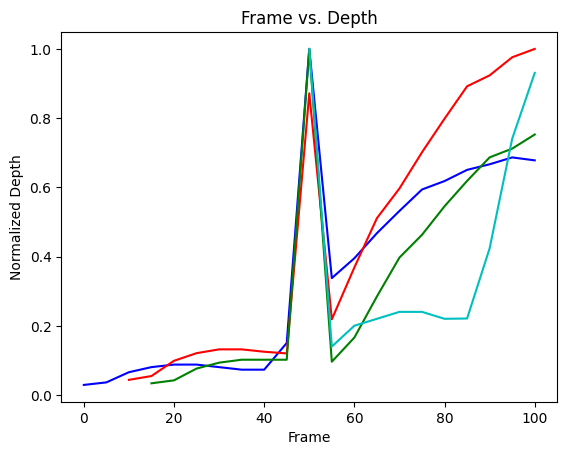

In [ ]:
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in x:
  x[i] *= 5

plt.title("Frame vs. Depth")
plt.xlabel('Frame')
plt.ylabel('Normalized Depth')

# some color options - b,g,r,c,m,y,k
plt.plot(x, norm_pommel, 'b')
plt.plot(x[21 - len(norm_handle):], norm_handle, 'r')
plt.plot(x[21 - len(norm_blade):], norm_blade, 'g')
plt.plot(x[21 - len(norm_rock):], norm_rock, 'c')

In [ ]:
def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
   deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
   runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
   for coOrd in deltaVals:
       runningSquared += coOrd**2
   return runningSquared**(1/2)
def findVec(point1,point2,unitSphere = False):
  #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
  finalVector = [0 for coOrd in point1]
  for dimension, coOrd in enumerate(point1):
      #finding total differnce for that co-ordinate(x,y,z...)
      deltaCoOrd = point2[dimension]-coOrd
      #adding total difference
      finalVector[dimension] = deltaCoOrd
  if unitSphere:
      totalDist = multiDimenDist(point1,point2)
      unitVector =[]
      for dimen in finalVector:
          unitVector.append( dimen/totalDist)
      return unitVector
  else:
      return finalVector

In [ ]:

findVec([0,0,0], [1,2,3])

[1, 2, 3]